# Use data pipelines for ingest and transformation

This workflow illustrates how a reusable data pipeline can be constructed to keep the datasets cataloged inside DataRobot up-to-date and ready for experimentation, batch predictions, or automated retraining jobs. It leverages DataRobot's Python client along with some configured environment variables to produce a pipeline that you can not only schedule, but also use as a template to ingest and prepare more datasets using a similar connection.

This example assumes that an existing connection has already been configured for Snowflake, and that credentials are saved inside DataRobot. Reference the documentation to learn about [creating connections to your data stores](https://docs.datarobot.com/en/docs/data/connect-data/data-conn.html). Alternatively, you can use this workflow as a guide to transform and catalog data collected through an API or other programmatic tool.

## What is a data pipeline?

A data pipeline is a series of processing tasks that configure data for analysis. Organizations can accumulate a significant amount of unprocessed data, collected from various sources, with the intention of performing analysis on that data; however, that raw data is often not useful. You must move, sort, filter, reformat, and analyze data for it to be effective. A data pipeline includes tools to identify and analyze patterns in data to inform actions. For example, a data pipeline might prepare data so that you can extract value from the data after examining it.

### Add environment variables

Assuming a data store connection and credentials are available in DataRobot, you can supply the following secrets in your DataRobot Notebook. For more information, reference the documentation for [adding environment variables](https://docs.datarobot.com/en/docs/dr-notebooks/code-nb/dr-env-nb.html#environment-variables).

| Variable | Description |
| --- | :----------- |
| `connection_name` | The name of the [connection object](https://app.datarobot.com/account/data-connections) in DataRobot. |
| `credential_name` | The name of the [credential object](https://app.datarobot.com/account/credentials-management) in DataRobot. |
| `datasource_name` | The name of the data source object used to query data via the supplied connection (this does not need to be created ahead of time, and can be any string). |
| `ingest_table_name` | The name of the table in the target data store that you want to ingest. |
| `raw_dataset_name` | A name for the catalog item containing the raw data (this does not need to be created ahead of time, and can be any string*) |
| `transform_dataset_name` | A name for the catalog item containing the final transformed data (this does not need to be created ahead of time, and can be any string). |

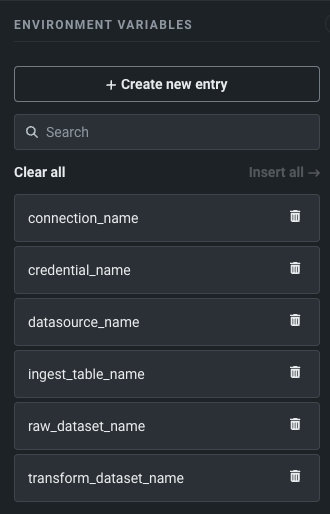

### Import libraries

In [ ]:
import datarobot as dr
import os

ingest_table_name = os.environ['ingest_table_name']
connection_name = os.environ['connection_name']
datasource_name = os.environ['datasource_name']
transform_dataset_name = os.environ['transform_dataset_name']
raw_dataset_name = os.environ['raw_dataset_name']
credential_name = os.environ['credential_name']

### Gather or create a data source

This cell searches for the appropriate data artifacts by the names supplied in the environment variables. The connection and credentials are required, and an exception will be raised if they are not available. If the datasource object is not already created, a new one will be made containing a query to fetch the target ingest table.

In [ ]:
try:
    connection = [c for c in dr.DataStore.list() if connection_name in c.canonical_name][0]
except:
    raise Exception("Specified connection is not configured.")

try:
    credential = [c for c in dr.Credential.list() if credential_name in c.name][0]
except:
    raise Exception("Specified credential is not configured.")

try:
    datasource = [s for s in dr.DataSource.list() if datasource_name in s.canonical_name][0]
except:
    query_train = ("SELECT * FROM " + ingest_table_name)
    ds_params = dr.DataSourceParameters(data_store_id=connection.id, query=query_train)
    datasource = dr.DataSource.create(data_source_type="jdbc", canonical_name=datasource_name, params=ds_params)

### Collect the raw data

Next, load the raw data into DataRobot's AI catalog. If the named dataset already exists, the pipeline will add a new version to the existing object.

In [ ]:
try:
    raw_dataset = [x for x in dr.Dataset.list() if raw_dataset_name in x.name][0]
    raw_dataset = dr.Dataset.create_version_from_data_source(raw_dataset.id, data_source_id=datasource.id, credential_id=credential.credential_id)
except:
    raw_dataset = dr.Dataset.create_from_data_source(data_source_id=datasource.id, do_snapshot=True, credential_id=credential.credential_id)
    raw_dataset.modify(name=raw_dataset_name)

### Transform data

This is where data transformations can be performed. The raw data is read into a dataframe that can then be manipulated as needed before updating the catalog with the final dataset.

In [ ]:
df = raw_dataset.get_as_dataframe()
df.drop(['policy_code', 'title', 'zip_code'], axis=1, inplace=True)
df = df.astype({"revol_bal": int, "revol_util": float})

### Save transformed data

Add the transformed data to the AI catalog for consumption in any downstream tasks.

In [ ]:
try:
    transformed_dataset = [x for x in dr.Dataset.list() if transform_dataset_name in x.name][0]
    transformed_dataset = dr.Dataset.create_version_from_in_memory_data(transformed_dataset.id, df)
except:
    transformed_dataset = dr.Dataset.create_from_in_memory_data(df)
    transformed_dataset.modify(name=transform_dataset_name)

### Scheduling and future use

DataRobot notebooks can be [scheduled](https://docs.datarobot.com/en/docs/workbench/wb-notebook/wb-manage-nb/wb-schedule-nb.html#notebook-scheduling) to run on a cadence that makes sense for the use case. Notebook scheduling allows the configured environment variables to be [overridden as parameters](https://docs.datarobot.com/en/docs/workbench/wb-notebook/wb-manage-nb/wb-schedule-nb.html#notebook-parameterization) for other jobs, so other tables can be ingested easily if they require the same transformations.

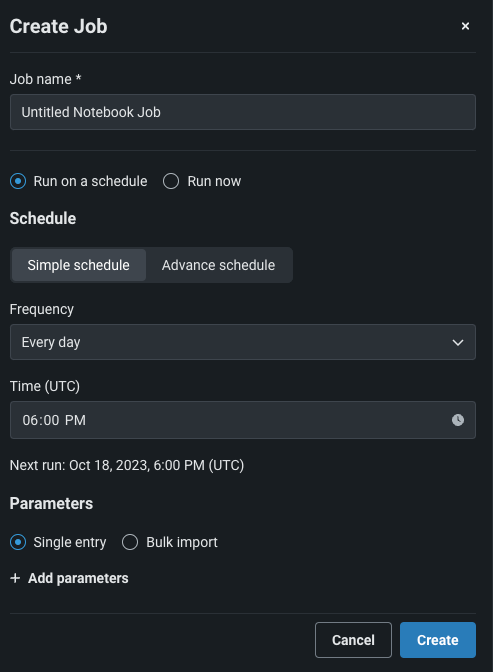